In [2]:
import os
import glob
import torch
import numpy as np
from skimage import io, transform
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("../src/models/")
from swin import BaseSwinUnet
from restormer import BaseRestormer
from bunet import BaseUnet
from noiseadding import build_noise_transforms, CombinedTransforms
from data import get_train_val_dataset, get_dataset, get_train_val_dataset
from metrics import ConfusionMatrix, RMSE
import torchvision

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def build_model(model, problem):
    if model == 'restormer':
        if problem == 'deraining':
            model = BaseRestormer(inp_channels=3, out_channels=3, dim=24)
        elif problem == 'denoise':
            model = BaseRestormer(inp_channels=1, out_channels=1, dim=24, activation='tanh')
        elif problem == 'firstbreak':
            model = BaseRestormer(inp_channels=1, out_channels=2, dim=24)
        else:
            raise ValueError('Undefined problem!')
    elif model == 'swin':
        if problem == 'deraining':
            model = BaseSwinUnet(in_chans=3, num_classes=3, embed_dim=48)
        elif problem == 'denoise':
            model = BaseSwinUnet(in_chans=1, num_classes=1, embed_dim=48, activation='tanh')
        elif problem == 'firstbreak':
            model = BaseSwinUnet(in_chans=1, num_classes=2, embed_dim=48)
        else:
            raise ValueError('Undefined problem!')
    elif model == 'unet':
        if problem == 'deraining':
            model = BaseUnet(in_channels=3, out_channels=3)
        elif problem == 'denoise':
            model = BaseUnet(in_channels=1, out_channels=1, activation='tanh')
        elif problem == 'firstbreak':
            model = BaseUnet(in_channels=1, out_channels=2)
        else:
            raise ValueError('Undefined problem!')
    else:
        raise ValueError('Undefined model!')
    return model

In [5]:
model_type='swin'
problem='firstbreak'
noise_type = 2
noise_scale = 2.0
batch_size=8
learning_rate=5e-5
workers=4
gpu_id=0
prefix=''
METADATA = '../metadata/'

In [6]:
model = build_model(model_type, 'firstbreak')
device = torch.device("cuda:" + str(gpu_id) if torch.cuda.is_available() else "cpu")
model.to(device)
noise_transforms = build_noise_transforms(noise_type=noise_type, scale=noise_scale)
denoise_dataset = get_dataset('firstbreak', noise_transforms=noise_transforms)
train_dataset, val_dataset = get_train_val_dataset(denoise_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
run_id = f'{model_type}_firstbreak_noisetype_{noise_type}_noisescale_{noise_scale}_dataclip_{True}_attack_fgsm_pretrained_{True}'
save_path = os.path.join(METADATA, run_id + '.pkl')
tb = SummaryWriter('/home/makam0a/tensorboard/denoising/logs/adversarial/' + run_id)
loss_fn = nn.CrossEntropyLoss()
metrics = ConfusionMatrix(2, train_loader.dataset.dataset.class_names)

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:2
---final upsample expand_first---


In [7]:
save_path = os.path.join(METADATA, run_id + '.pkl')
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


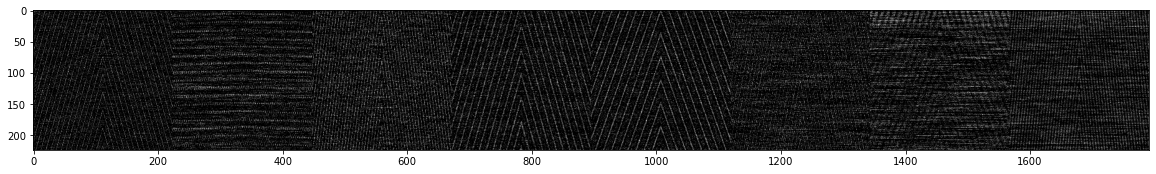

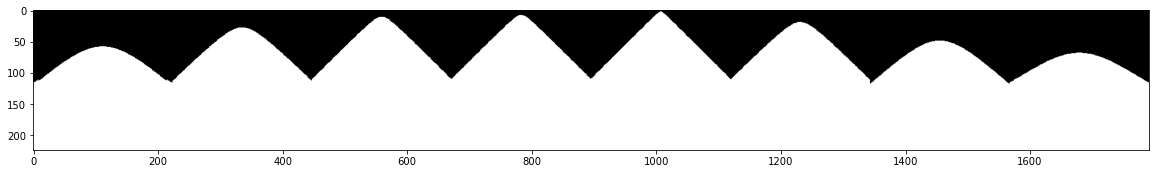

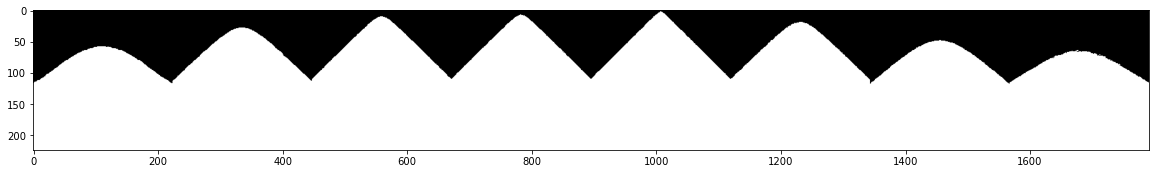

In [8]:
%pylab inline
model.eval() # set to evaluation mode

# Visualize validation sample
sample = iter(valid_loader).next()
x = sample['input'].to(device)
y_pred, y = model(x), sample['target']

figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['input'], padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['target'].float().unsqueeze(1), padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(y_pred.argmax(dim=1).detach().cpu().float().unsqueeze(1), padding=0).permute((1, 2, 0)))

In [116]:
from skimage.draw import random_shapes

def fgsm(model, X, y, epsilon=0.1, window=0.01, center=(0.8,0.7), max_shapes=5, **rand_args):
    """ Construct FGSM adversarial examples on the examples X"""
    inp =  torch.rand_like(X, requires_grad=True)
    delta = torch.fft.fft2(inp)
    delta = torch.fft.fftshift(delta)
    bs, ch, wx, wy = delta.shape
    image, _ = random_shapes((wx, wy), shape='rectangle', max_shapes=max_shapes, channel_axis=None, **rand_args)
    image[image<255] = 1
    image[image==255] = 0
    image = np.repeat(image[None, None,...],bs,0)
    mask = torch.from_numpy(image).to(device)
    delta = torch.mul(delta, mask)
    plt.imshow(delta[0,0].detach().cpu().abs(), vmax=80)
    plt.show()
    delta = torch.fft.ifft2(torch.fft.ifftshift(delta))
    delta = torch.real(delta)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * inp.grad.detach().sign()

def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct PGD adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)    
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

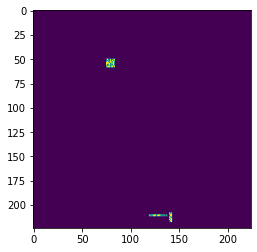

In [128]:
### Illustrate attacked images
delta = fgsm(model, x, y.to(device),1.0, max_shapes=5, max_size=20)
pred_att = model(x + delta)

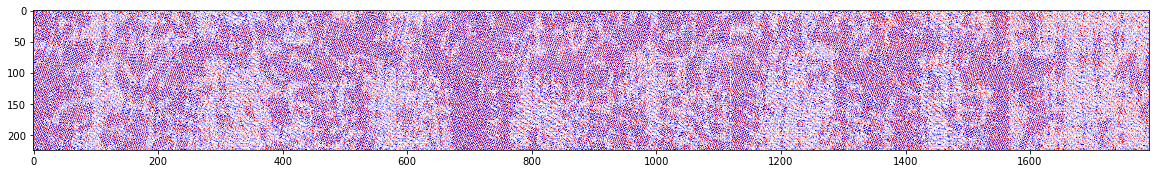

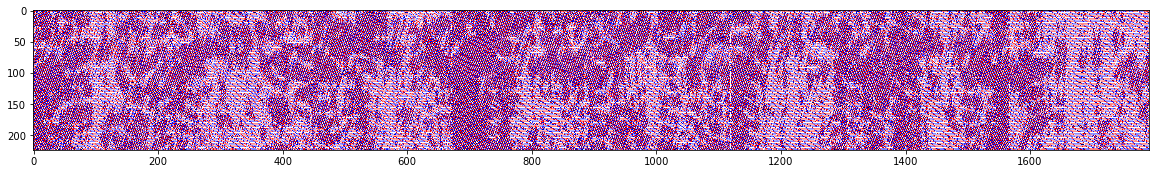

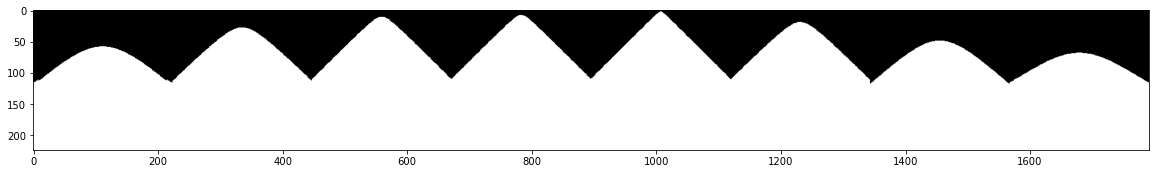

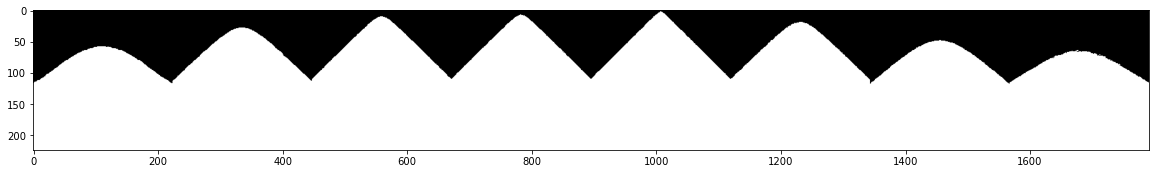

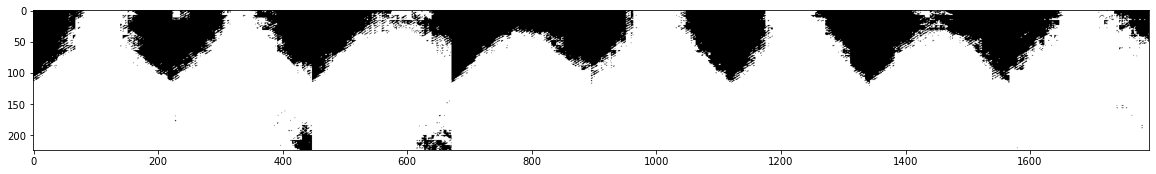

In [129]:
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid((x + delta).detach().cpu(), padding=0)[0,...][None,...].permute((1, 2, 0)), cmap='seismic')
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(delta.cpu(), padding=0)[0,...][None,...].permute((1, 2, 0)), cmap='seismic')
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['target'].float().unsqueeze(1), padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(y_pred.argmax(dim=1).detach().cpu().float().unsqueeze(1), padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(pred_att.argmax(dim=1).detach().cpu().float().unsqueeze(1), padding=0).permute((1, 2, 0)))

In [125]:
def evaluate(metrics):
    metrics.reset()
    for i, (sample) in enumerate(valid_loader):
        x, y = sample['input'].float().to(device), sample['target'].numpy()
        with torch.no_grad():
            y_pred = model(x)
            if problem == 'firstbreak':
                y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction
        metrics.add_batch(y, y_pred.detach().cpu().numpy())
        print('_', end='')
    return metrics.get()

def evaluate_attacks(attack, *pargs, **kwargs):
    m1 = ConfusionMatrix(2, train_loader.dataset.dataset.class_names)
    m2 = ConfusionMatrix(2, train_loader.dataset.dataset.class_names)
    sample = iter(valid_loader).next()
    x, y = sample['input'].float().to(device), sample['target'].to(device)
    with torch.no_grad():
        y_pred = model(x)
        if problem == 'firstbreak':
            y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction
    delta = attack(model, x, y, *pargs, **kwargs)
    with torch.no_grad():
        pred_att = model(x + delta)
    if problem == 'firstbreak':
        pred_att = torch.argmax(pred_att, dim=1)
    m1.add_batch(y.detach().cpu().numpy(), y_pred.detach().cpu().numpy())
    m2.add_batch(y.detach().cpu().numpy(), pred_att.detach().cpu().numpy())
    print('_', end='')
    return m1.get(), m2.get()

mIoU = evaluate(ConfusionMatrix(2, train_loader.dataset.dataset.class_names))
print(mIoU)
mIoU, mIoU_a = evaluate_attacks(pgd_linf ,epsilon=0.1)
print(mIoU, mIoU_a)

___________________________0.99627042938334
_0.9972765459789434 0.6363944591468644


In [19]:
epsilons = np.linspace(0.01,0.5,20)
mious = []
for epsilon in epsilons:
    _, miou = evaluate_attacks(pgd_linf, epsilon=epsilon)
    mious.append(miou)

____________________

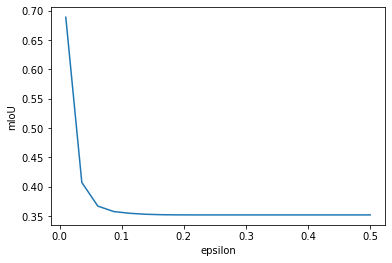

In [21]:
plt.plot(epsilons, mious)
plt.ylabel('mIoU')
plt.xlabel('epsilon')
plt.show()

In [6]:
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [7]:
def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


In [8]:
class AverageMeter(object):
    def __init__(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def epoch(model, attack=None, opt=None, tb=None, global_step=0, **att_args):
    """Standard training/evaluation epoch over the dataset"""
    suffix = '' if attack is None else "_attacked"
    losses = AverageMeter()
    metrics = ConfusionMatrix(2, train_loader.dataset.dataset.class_names)
    for i, (sample) in enumerate(train_loader):

        # Load a batch and send it to GPU
        x = sample['input'].to(device)
        y = sample['target'].to(device)
        # add attacks
        if attack is not None:
            x += attack(model, x, y, **att_args)
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)

        # Record loss
        losses.update(loss.data.item(), x.size(0))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        if opt:
            opt.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            opt.step()
        
    # Validation after each epoch
    model.eval()
    metrics.reset()
    for i, (sample) in enumerate(valid_loader):
        x, y = sample['input'].float().to(device), sample['target'].to(device)
        if attack is not None:
            x += attack(model, x, y, **att_args)
        with torch.no_grad():
            y_pred = model(x)
            if problem == 'firstbreak':
                y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction
        metrics.add_batch(y.detach().cpu().numpy(), y_pred.detach().cpu().numpy())
        print('_', end='')
    input_ = torchvision.utils.make_grid(x, padding=1)[0][None, ...]
    preds_ = torchvision.utils.make_grid(y_pred.unsqueeze(1), padding=1)
    if tb is not None:
        tb.add_image("inputs" + suffix, input_, global_step=global_step)
        tb.add_image("preds" + suffix, preds_, global_step=global_step)
    print(f'\nValidation stats ({metrics.name}):', metrics.get())
    return losses.avg, metrics.get()

In [9]:
pretrained = False
model = build_model(model_type, 'firstbreak')
model.to(device)
save_path = os.path.join(METADATA, run_id + '.pkl')
if pretrained:
    model.load_state_dict(torch.load(save_path))

Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [12]:
attack = False
att_id = f'{model_type}_{problem}_attack_{attack}_pretrained_{pretrained}'
save_path = os.path.join(METADATA, att_id + '.pkl')
tb = SummaryWriter('/home/makam0a/tensorboard/denoising/logs/adversarial/' + att_id)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10
for i in range(epochs):
    l, m = epoch(model, opt=optimizer, tb=tb, global_step=i)
    la, ma = epoch(model, attack=fgsm, tb=tb, global_step=i)
    print(l, m)
    print(la, ma)
    tb.add_scalar("Loss", l, i)
    tb.add_scalar(f"Loss_attacked", la, i)
    tb.add_scalar("IoU", m, i)
    tb.add_scalar(f"IoU_attacked", ma, i)

___________________________
Validation stats (mIoU): 0.9981150108873135
___________________________
Validation stats (mIoU): 0.4250332681355832
0.31482456408956516 0.9981150108873135
0.5836453746449772 0.4250332681355832
___________________________
Validation stats (mIoU): 0.9978160723429743
___________________________
Validation stats (mIoU): 0.40203701035117445
0.3140804857577918 0.9978160723429743
0.5954989892131878 0.40203701035117445
___________________________
Validation stats (mIoU): 0.9977975329340145
___________________________
Validation stats (mIoU): 0.3554416999526518
0.3139484885853541 0.9977975329340145
0.6193892084827463 0.3554416999526518
___________________________
Validation stats (mIoU): 0.9987169287539601
___________________________
Validation stats (mIoU): 0.3556575130742049
0.31387571799930036 0.9987169287539601
0.6194674633833848 0.3556575130742049
___________________________
Validation stats (mIoU): 0.9989137219070006
___________________________
Validation stats

In [14]:
tb.close()

In [15]:
pretrained = False
model = build_model(model_type, 'firstbreak')
model.to(device)
save_path = os.path.join(METADATA, run_id + '.pkl')
if pretrained:
    model.load_state_dict(torch.load(save_path))

Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [17]:
attack = True
att_id = f'{model_type}_{problem}_attack_{attack}_pretrained_{pretrained}'
save_path = os.path.join(METADATA, att_id + '.pkl')
tb = SummaryWriter('/home/makam0a/tensorboard/denoising/logs/adversarial/' + att_id)

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10
for i in range(epochs):
    l, m = epoch(model, tb=tb, global_step=i)
    la, ma = epoch(model, attack=fgsm, opt=optimizer, tb=tb, global_step=i)
    print(l, m)
    print(la, ma)
    tb.add_scalar("Loss", l, i)
    tb.add_scalar(f"Loss_attacked", la, i)
    tb.add_scalar("IoU", m, i)
    tb.add_scalar(f"IoU_attacked", ma, i)
    
save_path = os.path.join(METADATA, att_id + '.pkl')
torch.save(model.state_dict(), save_path)
tb.close()

___________________________
Validation stats (mIoU): 0.32260908479843386
___________________________
Validation stats (mIoU): 0.9925927373042982
0.6692487868622914 0.32260908479843386
0.34780930048264797 0.9925927373042982
___________________________
Validation stats (mIoU): 0.9915717841353806
___________________________
Validation stats (mIoU): 0.9963371800682451
0.3170248308771561 0.9915717841353806
0.3158127303768254 0.9963371800682451
___________________________
Validation stats (mIoU): 0.9868848584659373
___________________________
Validation stats (mIoU): 0.9970557723058181
0.3189420187748203 0.9868848584659373
0.3149541945077588 0.9970557723058181
___________________________
Validation stats (mIoU): 0.9918911098856766
___________________________
Validation stats (mIoU): 0.9963604868848884
0.31671665668237636 0.9918911098856766
0.31619864989626584 0.9963604868848884
___________________________
Validation stats (mIoU): 0.9957456354479026
___________________________
Validation stat

In [13]:
def evaluate(metrics):
    metrics.reset()
    for i, (sample) in enumerate(valid_loader):
        x, y = sample['input'].float().to(device), sample['target'].numpy()
        with torch.no_grad():
            y_pred = model(x)
            if problem == 'firstbreak':
                y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction
        metrics.add_batch(y, y_pred.detach().cpu().numpy())
        print('_', end='')
    return metrics.get()

In [7]:
import numpy as np
1 / np.array([0.25, 0.5, 1.0, 2.0]) / 4

array([1.   , 0.5  , 0.25 , 0.125])